In [89]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar
import pandas as pd
import datetime
from scipy.stats import linregress
import re

## input site name

In [90]:
site = 'harts'

In [91]:
ds = xr.open_dataset('/home/cdalden/summa_setup/analysis/crust_stats_harts.nc')
# ds.crusts_binary.values
ds


<xarray.Dataset>
Dimensions:          (time: 25, model_run: 7, site: 38)
Coordinates:
  * time             (time) datetime64[ns] 2000-01-01 2001-01-01 ... 2024-01-01
  * model_run        (model_run) object 'current' '+1K' '+2K' ... '+5K' '+6K'
  * site             (site) object 'harts' 'salmon' ... 'poperidge'
Data variables:
    mean_crusts      (time, model_run, site) float64 ...
    crust_days       (time, model_run, site) float64 ...
    snow_on          (time, model_run, site) float64 ...
    crusts_binary    (time, model_run, site) float64 ...
    isothermal_days  (time, model_run, site) float64 ...

['current' '+1K' '+2K' '+3K' '+4K']


/tmp/ipykernel_10131/695505766.py:39: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(years_np, crust_days_np, marker=markers[i % len(markers)], label=model_run, color='cadetblue', ec='k')
/tmp/ipykernel_10131/695505766.py:39: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(years_np, crust_days_np, marker=markers[i % len(markers)], label=model_run, color='cadetblue', ec='k')


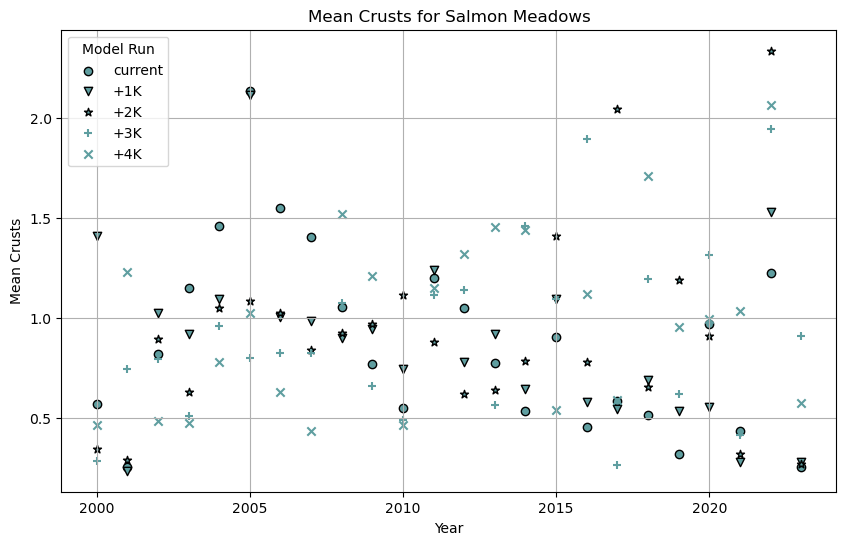

In [92]:

# Define a list of markers
markers = ['o', 'v', '*', '+', 'x', 'D', 'd', '|', '_']

# Filter the dataset for the 'harts' site
ds_harts = ds.sel(site=site)
# ds_harts = ds

# Select only the 'model_run' values 'current', '+2K', and '+4K'
ds_harts = ds_harts.where(ds_harts.model_run.isin(['current', '+1K', '+2K', '+3K', '+4K']), drop=True)

# Get the unique 'model_run' values
model_runs = ds_harts.model_run.values
print(model_runs)

# Create a new figure
plt.figure(figsize=(10, 6))

# Loop over the unique 'model_run' values
# Loop over the unique 'model_run' values
for i, model_run in enumerate(model_runs):
    # Select the 'mean_crusts' variable for the current 'model_run'
    crust_days = ds_harts['mean_crusts'].sel(model_run=model_run)*3 # will fix later, just to mask snow off for time being

    # Convert the time dimension to years for the x-axis
    years = crust_days.time.dt.year

    # Convert years and crust_days to numpy arrays
    years_np = years.values
    crust_days_np = crust_days.values

    # Remove NaN values
    mask = ~np.isnan(years_np) & ~np.isnan(crust_days_np)
    years_np = years_np[mask]
    crust_days_np = crust_days_np[mask]

    # Check if the arrays are not empty
    if years_np.size > 0 and crust_days_np.size > 0:
        # Plot the data with a different marker for each 'model_run'
        plt.scatter(years_np, crust_days_np, marker=markers[i % len(markers)], label=model_run, color='cadetblue', ec='k')

        # Calculate the coefficients of the linear regression line
        slope, intercept, r_value, p_value, std_err = linregress(years_np, crust_days_np)

                # Calculate R-squared
        r_squared = r_value**2

        # Generate the x values for the regression line
        x = np.linspace(years_np.min(), years_np.max(), 100)

        # Generate the y values for the regression line
        y = slope * x + intercept

        # Plot the regression line
        # plt.plot(x, y, label=f'{model_run} regression, R²={r_squared:.2f}')

# Add labels and a legend
plt.xlabel('Year')
plt.ylabel('Mean Crusts')
plt.title('Mean Crusts for Salmon Meadows')
plt.legend(title='Model Run')
plt.grid(True)

# Show the plot
plt.show()

In [93]:
# Create a dictionary to store the average values
average_values = {}

# Loop over the unique 'model_run' values
for i, model_run in enumerate(model_runs):
    # Select the 'crust_days' variable for the current 'model_run'
    crust_days = ds_harts['mean_crusts'].sel(model_run=model_run)*3 # will fix later, just to mask snow off for time being

    # Calculate the average value and store it in the dictionary
    average_values[model_run] = crust_days.mean().values

# Print the average values
for model_run, average_value in average_values.items():
    print(f"Average value for {model_run}: {np.round(average_value,3)}")

Average value for current: 0.874
Average value for +1K: 0.878
Average value for +2K: 0.918
Average value for +3K: 0.913
Average value for +4K: 0.987


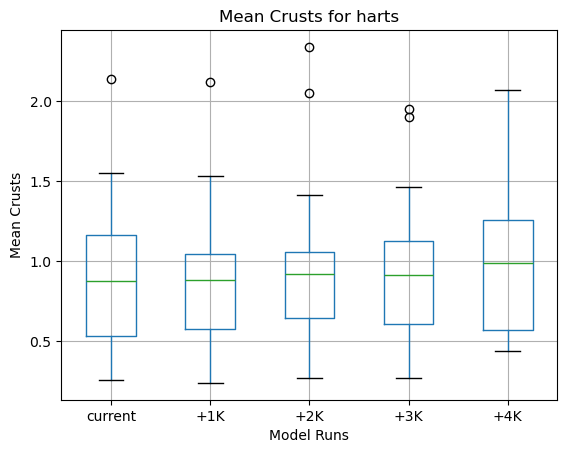

In [94]:
# Initialize an empty DataFrame
df = pd.DataFrame()

# Loop over the unique 'model_run' values
for i, model_run in enumerate(model_runs):
    # Select the 'crust_days' variable for the current 'model_run'
    crust_days = ds_harts['mean_crusts'].sel(model_run=model_run)*3 # will fix later, just to mask snow off for time being
    # Add the 'crust_days' values to the DataFrame
    df[model_run] = crust_days

# Create the box and whisker plots
boxplot = df.boxplot(grid=True, vert=True, return_type='dict')

# Add a horizontal line for the mean value of each column
for line, mean in zip(boxplot['medians'], df.mean()):
    line.set_ydata([mean, mean])

# Set the labels
plt.ylabel('Mean Crusts')
plt.xlabel('Model Runs')
plt.title(f'Mean Crusts for {site}')

# Show the plot
plt.show()

### Plot # of days with a crust (binary)

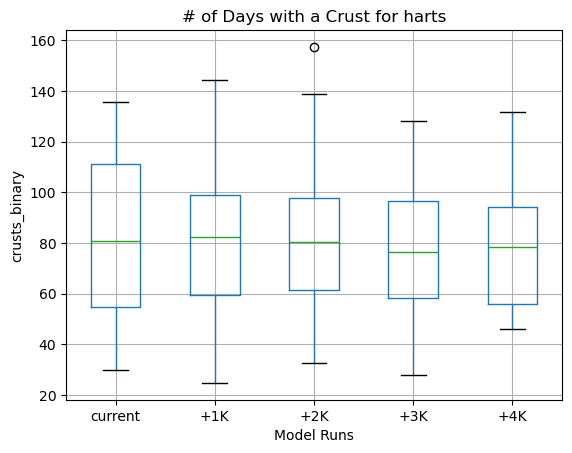

In [95]:
# Initialize an empty DataFrame
df = pd.DataFrame()

# Loop over the unique 'model_run' values
for i, model_run in enumerate(model_runs):
    # Select the 'crust_days' variable for the current 'model_run'
    crusts_binary = ds_harts['crusts_binary'].sel(model_run=model_run)
    # Add the 'crust_days' values to the DataFrame
    df[model_run] = crusts_binary/24

# Create the box and whisker plots
boxplot = df.boxplot(grid=True, vert=True, return_type='dict')

# Add a horizontal line for the mean value of each column
for line, mean in zip(boxplot['medians'], df.mean()):
    line.set_ydata([mean, mean])

# Set the labels
plt.ylabel('crusts_binary')
plt.xlabel('Model Runs')
plt.title(f'# of Days with a Crust for {site}')

# Show the plot
plt.show()

In [96]:
# Loop over the unique 'model_run' values
for i, model_run in enumerate(model_runs):
    # Select the 'crust_days' variable for the current 'model_run'
    crusts_binary = ds_harts['crusts_binary'].sel(model_run=model_run)/24 # will fix later, just to mask snow off for time being

    # Calculate the average value and store it in the dictionary
    average_values[model_run] = crusts_binary.mean().values

# Print the average values
print('Average # of days with a crust per year')
for model_run, average_value in average_values.items():
    print(f"Average value for {model_run}: {np.round(average_value,3)}")

Average # of days with a crust per year
Average value for current: 80.625
Average value for +1K: 82.224
Average value for +2K: 80.201
Average value for +3K: 76.373
Average value for +4K: 78.427


### Plot snow on days

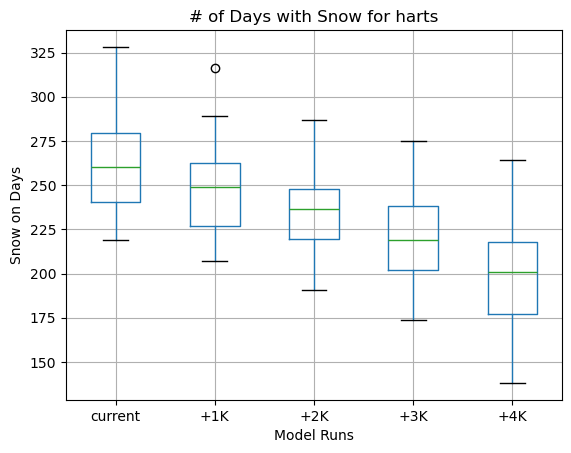

In [97]:
# Initialize an empty DataFrame
df = pd.DataFrame()

# Loop over the unique 'model_run' values
for i, model_run in enumerate(model_runs):
    # Select the 'crust_days' variable for the current 'model_run'
    snow_on = ds_harts['snow_on'].sel(model_run=model_run)
    # Add the 'crust_days' values to the DataFrame
    df[model_run] = snow_on/24

# Create the box and whisker plots
boxplot = df.boxplot(grid=True, vert=True, return_type='dict')

# Add a horizontal line for the mean value of each column
for line, mean in zip(boxplot['medians'], df.mean()):
    line.set_ydata([mean, mean])

# Set the labels
plt.ylabel('Snow on Days')
plt.xlabel('Model Runs')
plt.title(f'# of Days with Snow for {site}')

# Show the plot
plt.show()

In [98]:
# Loop over the unique 'model_run' values
for i, model_run in enumerate(model_runs):
    # Select the 'crust_days' variable for the current 'model_run'
    snow_on = ds_harts['snow_on'].sel(model_run=model_run)/24 # will fix later, just to mask snow off for time being

    # Calculate the average value and store it in the dictionary
    average_values[model_run] = snow_on.mean().values

# Print the average values
print('Average # of days with snow per year')
for model_run, average_value in average_values.items():
    print(f"Average value for {model_run}: {np.round(average_value,3)}")

Average # of days with snow per year
Average value for current: 260.03
Average value for +1K: 249.219
Average value for +2K: 236.587
Average value for +3K: 218.807
Average value for +4K: 201.156


## Percent of snow days with a crust

In [99]:
ds_harts['percent_crust_days'] = ds_harts['crusts_binary']/ds_harts['snow_on']*100

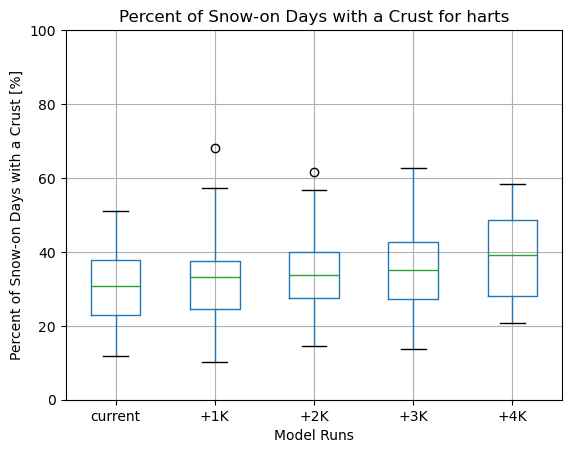

In [100]:
# Initialize an empty DataFrame
df = pd.DataFrame()

# Loop over the unique 'model_run' values
for i, model_run in enumerate(model_runs):
    # Select the 'percent_crust_days' variable for the current 'model_run'
    percent_crust_days = ds_harts['percent_crust_days'].sel(model_run=model_run)
    # Add the 'crust_days' values to the DataFrame
    df[model_run] = percent_crust_days

# Create the box and whisker plots
boxplot = df.boxplot(grid=True, vert=True, return_type='dict')

# Add a horizontal line for the mean value of each column
for line, mean in zip(boxplot['medians'], df.mean()):
    line.set_ydata([mean, mean])


plt.ylim(0, 100)

# Set the labels
plt.ylabel('Percent of Snow-on Days with a Crust [%]')
plt.xlabel('Model Runs')
plt.title(f'Percent of Snow-on Days with a Crust for {site}')
# plt.title(f'Percent of Snow-on Days with a Crust for Salmon Meadows')


# Show the plot
plt.show()

['current' '+1K' '+2K' '+3K' '+4K']


/tmp/ipykernel_10131/1194771451.py:38: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(years_np, percent_crust_days, marker=markers[i % len(markers)], label=model_run, color='cadetblue', ec='k')
/tmp/ipykernel_10131/1194771451.py:38: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(years_np, percent_crust_days, marker=markers[i % len(markers)], label=model_run, color='cadetblue', ec='k')


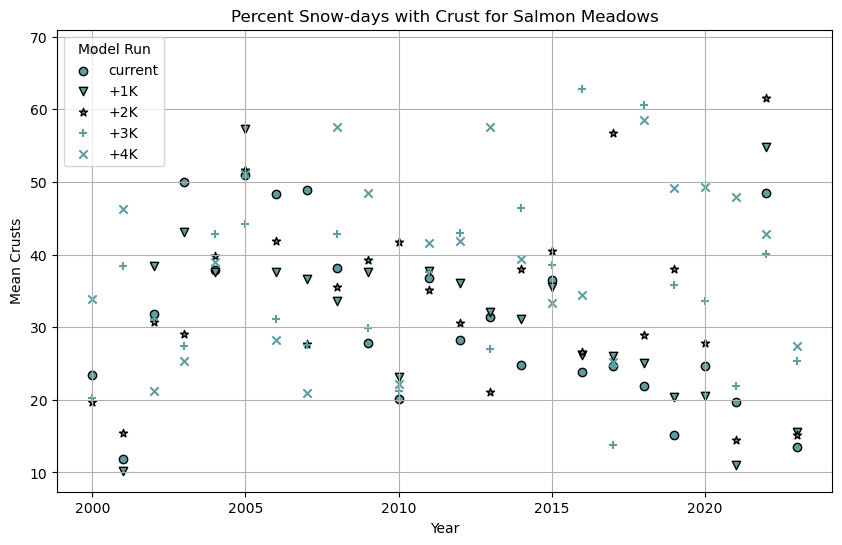

In [101]:

# Define a list of markers
markers = ['o', 'v', '*', '+', 'x', 'D', 'd', '|', '_']

# Filter the dataset for the 'harts' site
# ds_harts = ds.sel(site=site)

# Select only the 'model_run' values 'current', '+2K', and '+4K'
ds_harts = ds_harts.where(ds_harts.model_run.isin(['current', '+1K', '+2K', '+3K', '+4K']), drop=True)

# Get the unique 'model_run' values
model_runs = ds_harts.model_run.values
print(model_runs)

# Create a new figure
plt.figure(figsize=(10, 6))

# Loop over the unique 'model_run' values
# Loop over the unique 'model_run' values
for i, model_run in enumerate(model_runs):
    # Select the 'mean_crusts' variable for the current 'model_run'
    percent_crust_days = ds_harts['percent_crust_days'].sel(model_run=model_run) # will fix later, just to mask snow off for time being

    # Convert the time dimension to years for the x-axis
    years = percent_crust_days.time.dt.year

    # Convert years and crust_days to numpy arrays
    years_np = years.values
    percent_crust_days = percent_crust_days.values

    # Remove NaN values
    mask = ~np.isnan(years_np) & ~np.isnan(percent_crust_days)
    years_np = years_np[mask]
    percent_crust_days = percent_crust_days[mask]

    # Check if the arrays are not empty
    if years_np.size > 0 and percent_crust_days.size > 0:
        # Plot the data with a different marker for each 'model_run'
        plt.scatter(years_np, percent_crust_days, marker=markers[i % len(markers)], label=model_run, color='cadetblue', ec='k')

        # Calculate the coefficients of the linear regression line
        slope, intercept, r_value, p_value, std_err = linregress(years_np, percent_crust_days)

                # Calculate R-squared
        r_squared = r_value**2

        # Generate the x values for the regression line
        x = np.linspace(years_np.min(), years_np.max(), 100)

        # Generate the y values for the regression line
        y = slope * x + intercept

        # Plot the regression line
        # plt.plot(x, y, label=f'{model_run} regression, R²={r_squared:.2f}')

# Add labels and a legend
plt.xlabel('Year')
plt.ylabel('Mean Crusts')
plt.title('Percent Snow-days with Crust for Salmon Meadows')
plt.legend(title='Model Run')
plt.grid(True)

# Show the plot
plt.show()

In [102]:
# Loop over the unique 'model_run' values
for i, model_run in enumerate(model_runs):
    # Select the 'crust_days' variable for the current 'model_run'
    percent_crust_days = ds_harts['percent_crust_days'].sel(model_run=model_run) # will fix later, just to mask snow off for time being

    # Calculate the average value and store it in the dictionary
    average_values[model_run] = percent_crust_days.mean().values

# Print the average values
print('Percent of snow on days with a crust per year')
for model_run, average_value in average_values.items():
    print(f"Average value for {model_run}: {np.round(average_value,3)}")

Percent of snow on days with a crust per year
Average value for current: 30.801
Average value for +1K: 33.134
Average value for +2K: 33.616
Average value for +3K: 35.131
Average value for +4K: 39.283


# SCRATCH